**Hand Gesture Classification**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d aryarishabh/hand-gesture-recognition-dataset

 98% 37.0M/37.6M [00:03<00:00, 18.6MB/s]
100% 37.6M/37.6M [00:03<00:00, 12.8MB/s]


In [3]:
import zipfile
zip=zipfile.ZipFile("/content/hand-gesture-recognition-dataset.zip","r")
zip.extractall('/content')
zip.close()

**Importing Necessary libraries**

In [28]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.13.0


In [29]:
train_dir=Path("/content/train/train")
train_filepaths=list(train_dir.glob(r'**/*.jpg'))

In [30]:
test_dir=Path("/content/test/test")
test_filepaths=list(test_dir.glob(r'**/*.jpg'))

In [31]:
import pandas as pd

def image_processing(filepaths):
    # Ensure all filepaths are converted to strings
    filepaths = [str(filepath) for filepath in filepaths]

    # Extract labels from filepaths
    labels = [str(filepath).split("/")[-2] for filepath in filepaths]

    # Create a DataFrame with filepaths and labels
    df = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [32]:
train_df=image_processing(train_filepaths)
test_df=image_processing(test_filepaths)


In [33]:
print("---Trainig Set---\n")
print(f"Number of Images: {train_df.shape[0]}\n")
print(f"Number of different labels: {len(train_df.Label.unique())}\n")
print(f"Labels: {train_df.Label.unique()}")

---Trainig Set---

Number of Images: 18000

Number of different labels: 20

Labels: ['0' '12' '6' '7' '19' '10' '9' '17' '13' '3' '18' '11' '8' '16' '15' '4'
 '14' '2' '1' '5']


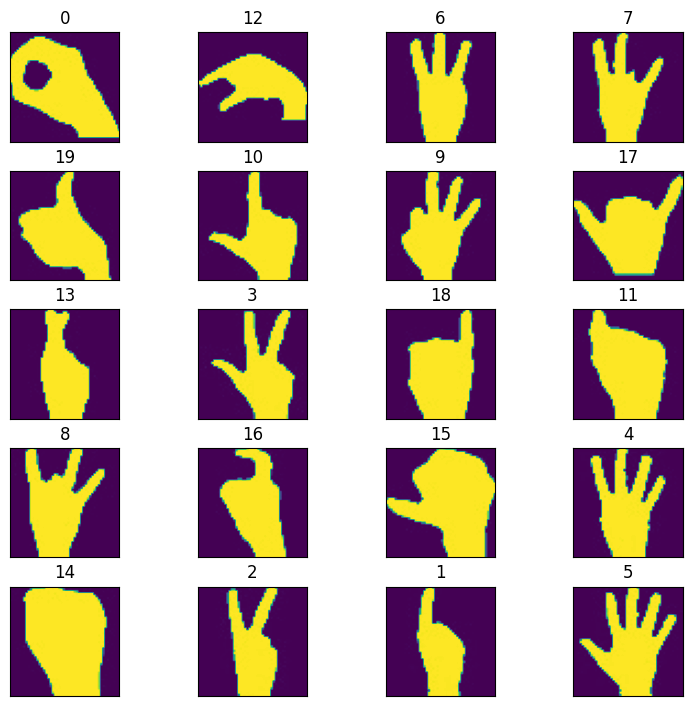

In [34]:
#Create a DataFrame with one label of each category
df_unique=train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

#Displaying Some Images of the dataset
fig,axes=plt.subplots(nrows=5,ncols=4,figsize=(8,7),subplot_kw={'xticks':[],'yticks':[]})

for i,ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.Filepath[i]))
  ax.set_title(df_unique.Label[i],fontsize=12)

plt.tight_layout(pad=0.5)
plt.show()

In [35]:
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [36]:
#Training the image to create a new image and identify(Data Augmentation)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,  # Corrected parameter name
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


Found 18000 validated image filenames belonging to 20 classes.


In [37]:
#Testing the image to test a new image and identify
test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=0,
)


Found 6000 validated image filenames belonging to 20 classes.


In [38]:
pretrained_model=tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)
pretrained_model.trainable=False

In [16]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
inputs = pretrained_model.input

x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer to avoid overfitting

x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout after a dense layer

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(pretrained_model.output)

outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=test_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
563/563 [==============================] - 56s 94ms/step - loss: 0.2448 - accuracy: 0.9857 - val_loss: 0.0933 - val_accuracy: 0.9975
Epoch 2/5
563/563 [==============================] - 41s 73ms/step - loss: 0.0600 - accuracy: 0.9991 - val_loss: 0.0633 - val_accuracy: 0.9955
Epoch 3/5
563/563 [==============================] - 41s 72ms/step - loss: 0.0535 - accuracy: 0.9954 - val_loss: 0.1396 - val_accuracy: 0.9798
Epoch 4/5
563/563 [==============================] - 44s 78ms/step - loss: 0.0514 - accuracy: 0.9979 - val_loss: 0.0315 - val_accuracy: 0.9992
Epoch 5/5
563/563 [==============================] - 39s 70ms/step - loss: 0.0416 - accuracy: 0.9967 - val_loss: 0.0544 - val_accuracy: 0.9958


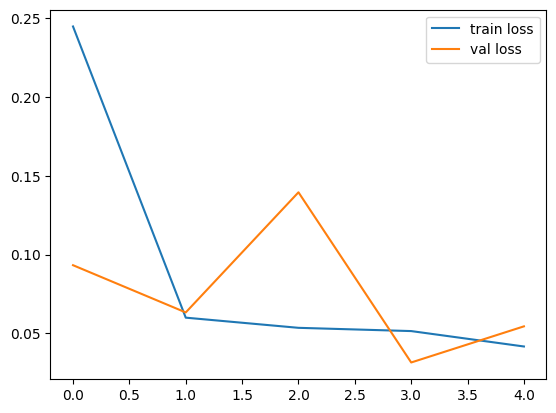

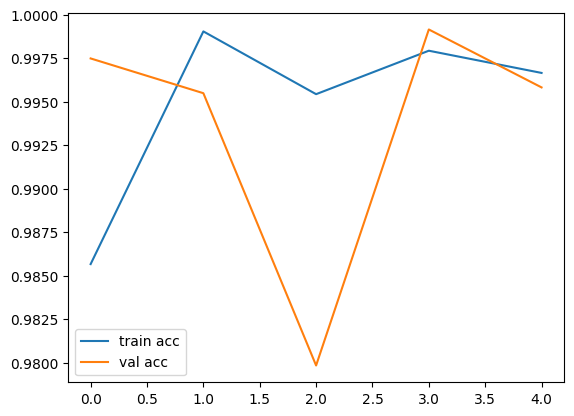

<Figure size 640x480 with 0 Axes>

In [39]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [40]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1


188/188 [==============================] - 10s 54ms/step


['9',
 '6',
 '15',
 '17',
 '5',
 '10',
 '3',
 '15',
 '10',
 '18',
 '14',
 '11',
 '1',
 '14',
 '19',
 '0',
 '12',
 '7',
 '2',
 '15',
 '17',
 '9',
 '12',
 '7',
 '18',
 '4',
 '1',
 '14',
 '17',
 '9',
 '9',
 '19',
 '3',
 '17',
 '17',
 '16',
 '7',
 '4',
 '12',
 '3',
 '8',
 '6',
 '14',
 '19',
 '0',
 '15',
 '4',
 '2',
 '7',
 '11',
 '15',
 '7',
 '9',
 '14',
 '7',
 '4',
 '3',
 '16',
 '9',
 '10',
 '8',
 '18',
 '18',
 '14',
 '13',
 '15',
 '11',
 '9',
 '11',
 '16',
 '5',
 '13',
 '15',
 '18',
 '18',
 '15',
 '12',
 '0',
 '17',
 '16',
 '18',
 '7',
 '16',
 '3',
 '10',
 '9',
 '5',
 '15',
 '18',
 '14',
 '15',
 '12',
 '1',
 '11',
 '3',
 '15',
 '0',
 '7',
 '7',
 '3',
 '0',
 '16',
 '15',
 '12',
 '17',
 '0',
 '14',
 '10',
 '10',
 '7',
 '14',
 '17',
 '9',
 '19',
 '13',
 '11',
 '14',
 '12',
 '11',
 '5',
 '0',
 '17',
 '5',
 '8',
 '11',
 '8',
 '14',
 '18',
 '14',
 '0',
 '10',
 '11',
 '4',
 '13',
 '1',
 '14',
 '1',
 '13',
 '6',
 '9',
 '4',
 '13',
 '16',
 '13',
 '17',
 '0',
 '1',
 '9',
 '6',
 '16',
 '2',
 '7',
 '

In [41]:
def output(location):
  img=load_img(location,target_size=(224,224,3))
  img=img_to_array(img)
  img=img/255
  img=np.expand_dims(img,[0])
  answer=model.predict(img)
  y_class=answer.argmax(axis=-1)
  y=" ".join(str(x) for x in y_class)
  y=int(y)
  res=labels[y]
  return res

1/1 [==============================] - 0s 91ms/step
The Predicted Hand Gesture is 2.


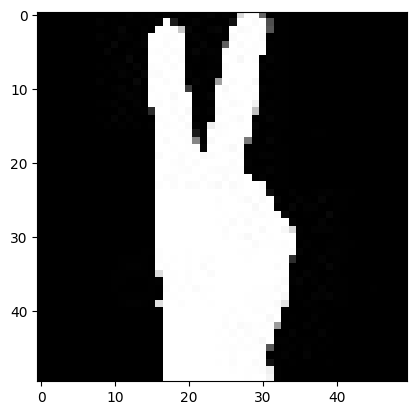

In [48]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2

test_img= cv2.imread("/content/test/test/2/1008.jpg")
plt.imshow(test_img)

predicted_gest=output("/content/test/test/2/1008.jpg")

print(f"The Predicted Hand Gesture is {predicted_gest}.")

1/1 [==============================] - 0s 37ms/step
The Predicted Hand Gesture is 4.


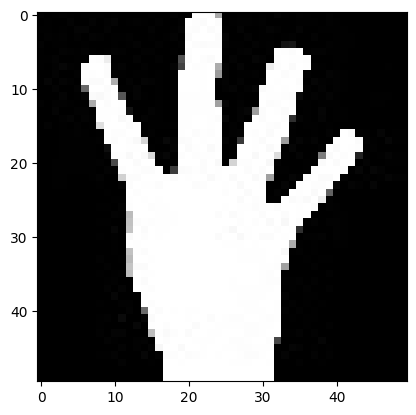

In [47]:
import numpy as np
from tensorflow.keras.preprocessing import image
import cv2

test_img= cv2.imread("/content/test/test/4/999.jpg")
plt.imshow(test_img)

predicted_gest=output("/content/test/test/4/999.jpg")

print(f"The Predicted Hand Gesture is {predicted_gest}.")